#Model

##Generator

In [ ]:
import torch
import torch.nn as nn


class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        add_activation: bool = True,
        **kwargs
    ):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True) if add_activation else nn.Identity(),
            )

    def forward(self, x):
        return self.conv(x)


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        """
        In a residual block, the use of two ConvBlock instances with one having
        an activation function and the other not is a design choice that promotes
        the learning of residual information.

        The purpose of a residual block is to learn the residual mapping between
        the input and output of the block. The first ConvBlock in the sequence,
        which includes an activation function, helps in capturing and extracting
        important features from the input. The activation function introduces
        non-linearity, allowing the network to model complex relationships
        between the input and output.

        The second ConvBlock does not include an activation function.
        It mainly focuses on adjusting the dimensions (e.g., number of channels)
        of the features extracted by the first ConvBlock. The absence of an
        activation function in the second ConvBlock allows the block to learn
        the residual information. By directly adding the output of the second
        ConvBlock to the original input, the block learns to capture the
        residual features or changes needed to reach the desired output.

        (Information and explanation above generated by ChatGPT)
        """
        super().__init__()
        self.block = nn.Sequential(
            ConvolutionalBlock(channels, channels, add_activation=True, kernel_size=3, padding=1),
            nn.Dropout2d(0.5),
            ConvolutionalBlock(channels, channels, add_activation=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        """
        This skip connection, achieved through the addition operation, helps
        in propagating gradients during training and alleviates the vanishing
        gradient problem. It also facilitates the flow of information from earlier
        layers to later layers, allowing the network to learn more effectively.

        (Information and explanation above generated by ChatGPT)
        """
        return x + self.block(x)


In [ ]:
class Generator(nn.Module):
    def __init__(
        self, img_channels: int, num_features: int = 64, num_residuals: int = 9
    ):
        """
        Generator consists of 2 layers of downsampling/encoding layer,
        followed by 9 residual blocks for 128 × 128 training images
        and then 3 upsampling/decoding layer.

        The network with 6 residual blocks can be written as:
        c7s1–64, d128, d256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1–3.

        The network with 9 residual blocks consists of:
        c7s1–64, d128, d256, R256, R256, R256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1–3.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.ReLU(inplace=True),
        )

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features,
                    num_features * 2,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 2,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 1,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))
    def encode(self, x):
       x = self.initial_layer(x)
       for layer in self.downsampling_layers:
            x = layer(x)
       x = self.residual_layers(x)
       return x
    def decode(self, x):
       for layer in self.upsampling_layers:
            x = layer(x)
       return torch.tanh(self.last_layer(x))


##Discriminator

In [ ]:
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        """
        Class object initialization for Convolution-InstanceNorm-LeakyReLU layer

        We use leaky ReLUs with a slope of 0.2.
        """
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=True,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(out_channels),
            nn.Dropout2d(0.7),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        """
        Let Ck denote a 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with
        k filters and stride 2. Discriminator architecture is: C64-C128-C256-C512.

        After the last layer, we apply a convolution to produce a 1-dimensional
        output.

        We use leaky ReLUs with a slope of 0.2.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                ConvInstanceNormLeakyReLUBlock(
                    in_channels,
                    feature,
                    stride=1 if feature == features[-1] else 2,
                )
            )
            in_channels = feature

        # After the last layer, we apply a convolution to produce a 1-dimensional output
        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)

        # feed the model output into a sigmoid function to make a 1/0 label
        return torch.sigmoid(self.model(x))

##Test

In [ ]:
G = Generator(3)
data = torch.empty([1, 3, 640, 640])
encoded = G.encode(data)
encoded.size()

torch.Size([1, 256, 160, 160])

In [ ]:
D = Discriminator(256)
out = D(encoded)
out.size()

torch.Size([1, 1, 18, 18])

#Dataset

In [ ]:
from PIL import Image
import os
from torch.utils.data import Dataset
import numpy as np
import cv2
import pandas as pd
from random import randint


In [ ]:
class MobileMachineUnpair(Dataset):
    def __init__(self, files_path, mapping, transform=None):
      self.transform = transform
      dir = files_path[0].split('/')[:-1]
      dir = '/'.join(dir)
      image_files_df = pd.DataFrame( { 'Image File':[file.split('/')[-1] for file in files_path] } )

      intersect = pd.merge(image_files_df, mapping, how ='inner', on ='Image File')

      intersect['Image File'] = intersect['Image File'].apply(lambda x: os.path.join(dir, x))

      self.mobile_positive = intersect[intersect['Type']=='mobile_positive']['Image File'].values
      self.mobile_negative = intersect[intersect['Type']=='mobile_negative']['Image File'].values

      self.machine_positive = intersect[intersect['Type']=='machine_positive']['Image File'].values
      self.machine_negative = intersect[intersect['Type']=='machine_negative']['Image File'].values

      self.len_map = len(self.machine_positive)
      self.len_mop =  len(self.mobile_positive)
      self.len_man = len(self.machine_negative)
      self.len_mon =  len(self.mobile_negative)


    def __len__(self):
      return max(self.len_mop, self.len_map) + max(self.len_mon, self.len_man)

    def __getitem__(self, idx):
      if idx <= self.len_map - 1:
        m_idx = idx
        if idx > self.len_mop - 1:
          m_idx = randint(0, self.len_mop-1)
        return self.transform(image=cv2.imread(self.machine_positive[idx]))['image'], self.transform(image=cv2.imread(self.mobile_positive[m_idx]))['image']
      else:
        idx -= self.len_map
        m_idx = idx
        if idx > self.len_mon - 1:
          m_idx = randint(0, self.len_mon-1)
        return self.transform(image=cv2.imread(self.machine_negative[idx]))['image'], self.transform(image=cv2.imread(self.mobile_negative[m_idx]))['image']

In [ ]:
class NewMobileMachineUnpair(Dataset):
    def __init__(self, machine_path, mobile_path, transform=None):
      self.machine_path = machine_path
      self.mobile_path = mobile_path
      self.transform = transform

    def __len__(self):
      return len(self.machine_path)

    def __getitem__(self, idx):
        return self.transform(image=cv2.imread(self.machine_path[idx]))['image'], self.transform(image=cv2.imread(self.mobile_path[idx]))['image']

In [ ]:
from glob import glob
import pandas as pd

train_machine_paths = glob('pytorch-CycleGAN-and-pix2pix/datasets/newdataset/trainA/*')
train_mobile_paths = glob('pytorch-CycleGAN-and-pix2pix/datasets/newdataset/trainB/*')
val_machine_paths = glob('pytorch-CycleGAN-and-pix2pix/datasets/newdataset/testA/*')
val_mobile_paths = glob('pytorch-CycleGAN-and-pix2pix/datasets/newdataset/testB/*')
val_file_paths = glob('datasets/val/images/*')
# mapping = pd.read_excel('mapping.xlsx')
len(train_machine_paths), len(train_mobile_paths), len(val_machine_paths), len(val_mobile_paths)

(13999, 13999, 3999, 3999)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/My Drive/AI/CycleGAN
# !ls

#Variables & Functions

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {DEVICE}")

TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
BATCH_SIZE = 2
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 0.0 # loss weight for identity loss
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 3
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_GENERATOR_H = "models/genhAE.pth.tar"
CHECKPOINT_GENERATOR_Z = "models/genzAE.pth.tar"
CHECKPOINT_DISCRIMINATOR_H = "models/disch.pth.tar"
CHECKPOINT_DISCRIMINATOR_Z = "models/discz.pth.tar"

transforms = A.Compose(
    [
        A.Resize(width=640, height=640),
        # A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)


using device: cuda


In [ ]:
import random, torch, os, numpy as np
import torch.nn as nn
import copy

def save_checkpoint(model, optimizer, filename="models/checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer=None, lr=None):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    if optimizer:
      optimizer.load_state_dict(checkpoint["optimizer"])

      for param_group in optimizer.param_groups:
          param_group["lr"] = lr


def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

##Train

In [ ]:
import torch
import sys
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision.utils import save_image

losses = {'D':[], 'G':[]}

def train_fn(
    disc_H, disc_Z, gen_Z, gen_H, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler
):
    H_reals = 0
    H_fakes = 0
    loop = tqdm(loader, leave=True)

    for idx, (machine, mobile) in enumerate(loop):
        torch.cuda.empty_cache()
        machine = machine.to(DEVICE)
        mobile = mobile.to(DEVICE)

        # Train discriminators H and Z
        with torch.cuda.amp.autocast():
            latent_machine = gen_H.encode(machine)
            latent_mobile = gen_Z.encode(mobile)

            D_H_real = disc_H(latent_mobile.detach()) #
            D_H_fake = disc_H(latent_machine.detach())
            H_reals += D_H_real.mean().item()
            H_fakes += D_H_fake.mean().item()
            D_H_real_loss = mse(D_H_real, torch.ones_like(D_H_real))
            D_H_fake_loss = mse(D_H_fake, torch.zeros_like(D_H_fake))
            D_H_loss = D_H_real_loss + D_H_fake_loss

            D_Z_real = disc_Z(latent_machine.detach())
            D_Z_fake = disc_Z(latent_mobile.detach())
            D_Z_real_loss = mse(D_Z_real, torch.ones_like(D_Z_real))
            D_Z_fake_loss = mse(D_Z_fake, torch.zeros_like(D_Z_fake))
            D_Z_loss = D_Z_real_loss + D_Z_fake_loss

            D_loss = (D_H_loss + D_Z_loss) / 2

        d_scaler.scale(D_loss).backward()
        if idx % 8 == 0:
          d_scaler.step(opt_disc)
          d_scaler.update()
          opt_disc.zero_grad()

        # Train generators H and Z
        with torch.cuda.amp.autocast():
            # adversarial losses
            D_H_fake = disc_H(latent_machine)
            D_Z_fake = disc_Z(latent_mobile)
            loss_G_H = mse(D_H_fake, torch.ones_like(D_H_fake))
            loss_G_Z = mse(D_Z_fake, torch.ones_like(D_Z_fake))

            # cycle losses
            cycle_machine = gen_Z.encode(machine)
            cycle_mobile = gen_H.encode(mobile)
            cycle_machine_loss = l1(latent_machine, cycle_machine)
            cycle_mobile_loss = l1(latent_mobile, cycle_mobile)

            # identity losses
            # identity_machine = gen_Z(machine)
            # identity_mobile = gen_H(mobile)
            # identity_machine_loss = l1(machine, identity_machine)
            # identity_mobile_loss = l1(mobile, identity_mobile)

            # total loss
            G_loss = (
                loss_G_Z
                + loss_G_H
                + cycle_machine_loss * LAMBDA_CYCLE
                + cycle_mobile_loss * LAMBDA_CYCLE
                # + identity_mobile_loss * LAMBDA_IDENTITY
                # + identity_machine_loss * LAMBDA_IDENTITY
            )
        losses['D'].append(D_loss.cpu().detach().numpy())
        losses['G'].append(G_loss.cpu().detach().numpy())

        g_scaler.scale(G_loss).backward()
        if idx % 2 == 0:
          g_scaler.step(opt_gen)
          g_scaler.update()
          opt_gen.zero_grad()


        # if idx % 500 == 0:
        #     with torch.no_grad():
        #       latent_machine = latent_machine.to(DEVICE)
        #       latent_mobile = latent_mobile.to(DEVICE)
        #       fake_mobile = gen_H.decode(latent_machine)
        #       fake_machine = gen_Z.decode(latent_mobile)
        #       save_image(fake_mobile * 0.5 + 0.5, f"outputs/mobile_{idx}.png")
        #       save_image(fake_machine * 0.5 + 0.5, f"outputs/machine_{idx}.png")

        loop.set_postfix(H_real=H_reals / (idx + 1), H_fake=H_fakes / (idx + 1), D_loss=D_loss, G_loss=G_loss)


#Train AE

In [ ]:
!nvidia-smi

Thu May 30 13:57:28 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:81:00.0 Off |                    0 |
| N/A   37C    P0    54W / 400W |  14065MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##DataLoader

In [ ]:
from torch.utils.data import DataLoader
dataset = NewMobileMachineUnpair(
    train_machine_paths,
    train_mobile_paths,
    transforms,
)
val_dataset = NewMobileMachineUnpair(
    val_machine_paths,
    val_mobile_paths,
    transforms,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    pin_memory=True,
)
loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

##Train

In [ ]:
gen_H = Generator(img_channels=3, num_residuals=9).to(DEVICE) # machine to mobile
gen_Z = Generator(img_channels=3, num_residuals=9).to(DEVICE) # mobile to machine

from torch.optim import AdamW
opt_gen = AdamW(list(gen_Z.upsampling_layers.parameters()) + list(gen_Z.last_layer.parameters()) + list(gen_H.upsampling_layers.parameters()) + list(gen_H.last_layer.parameters()), lr=2e-4, weight_decay=0.01)

In [ ]:
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

print('epoch: ', NUM_EPOCHS)

# opt_H = AdamW(gen_H.parameters(), lr=2e-3, weight_decay=0.01)
# opt_Z = AdamW(gen_Z.parameters(), lr=2e-3, weight_decay=0.01)


sch_gen = CosineAnnealingLR(opt_gen, T_max=NUM_EPOCHS)
# sch_Z = CosineAnnealingLR(opt_gen, T_max=NUM_EPOCHS)
loss_fn = nn.L1Loss()

g_scaler = torch.cuda.amp.GradScaler()

for epoch in range(1, NUM_EPOCHS+1):
  gen_H.train()
  gen_Z.train()

  loop = tqdm(loader, leave=True)

  for idx, (machine, mobile) in enumerate(loop):
    torch.cuda.empty_cache()
    machine = machine.to(DEVICE)
    mobile = mobile.to(DEVICE)

    with torch.cuda.amp.autocast():
      fake_machine = gen_H(machine)
      fake_mobile = gen_Z(mobile)

      loss_H = loss_fn(fake_machine, machine)
      loss_Z = loss_fn(fake_mobile, mobile)

      loss_G = loss_H + loss_Z

      # g_scaler.scale(loss_H).backward()
      # g_scaler.scale(loss_Z).backward()
      g_scaler.scale(loss_G).backward()

      if idx % 4 == 0:
        # g_scaler.step(opt_H)
        # g_scaler.step(opt_Z)
        g_scaler.step(opt_gen)
        g_scaler.update()

        # opt_H.zero_grad()
        # opt_Z.zero_grad()
        opt_gen.zero_grad()


    loop.set_postfix(Machine_Loss=loss_H.item(), Mobile_Loss=loss_Z.item())
  sch_gen.step()
  # sch_Z.step()

  if epoch % 3 == 0:
    gen_H.eval()
    gen_Z.eval()

    avg_loss_H = []
    avg_loss_Z = []

    val_loop = tqdm(val_loader, leave=True, position=0)

    with torch.no_grad():
      for idx, (machine, mobile) in enumerate(val_loop):
        torch.cuda.empty_cache()
        machine = machine.to(DEVICE)
        mobile = mobile.to(DEVICE)

        with torch.cuda.amp.autocast():
          fake_machine = gen_H(machine)
          fake_mobile = gen_Z(mobile)

          loss_H = loss_fn(fake_machine, machine)
          loss_Z = loss_fn(fake_mobile, mobile)

          avg_loss_H.append(loss_H.item())
          avg_loss_Z.append(loss_Z.item())

      val_loop.set_postfix(Machine_Loss=mean(avg_loss_H), Mobile_Loss=mean(avg_loss_Z))
if SAVE_MODEL:
  save_checkpoint(gen_H, opt_gen, filename=CHECKPOINT_GENERATOR_H)
  save_checkpoint(gen_Z, opt_gen, filename=CHECKPOINT_GENERATOR_Z)

epoch:  3


100%|█████████▉| 6999/7000 [16:57<00:00,  6.98it/s, Machine_Loss=0.0637, Mobile_Loss=0.103]/home/ai4034/.conda/envs/newenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:453: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
100%|██████████| 2000/2000 [06:02<00:00,  5.52it/s]


=> Saving checkpoint
=> Saving checkpoint


##Eval

In [ ]:
load_checkpoint(
    CHECKPOINT_GENERATOR_H,
    gen_H,
    opt_gen,
    LEARNING_RATE,
)
load_checkpoint(
    CHECKPOINT_GENERATOR_Z,
    gen_Z,
    opt_gen,
    LEARNING_RATE,
)

gen_H.eval()
gen_Z.eval()

=> Loading checkpoint
=> Loading checkpoint


Generator(
  (initial_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
    (1): ReLU(inplace=True)
  )
  (downsampling_layers): ModuleList(
    (0): ConvolutionalBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvolutionalBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
  )
  (residual_layers): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): ConvolutionalBlock(
          (conv): Sequential(
            (0): Conv2d(256, 256, ker

In [ ]:
from statistics import mean

gen_H.eval()
gen_Z.eval()
val_loop = tqdm(val_loader, leave=True, position=0)
avg_loss_H = []
avg_loss_Z = []
with torch.no_grad():
  for idx, (machine, mobile) in enumerate(val_loop):
    machine = machine.to(DEVICE)
    mobile = mobile.to(DEVICE)
    torch.cuda.empty_cache()

    with torch.cuda.amp.autocast():
      fake_machine = gen_H(machine)
      fake_mobile = gen_Z(mobile)

      loss_H = loss_fn(fake_machine, machine)
      loss_Z = loss_fn(fake_mobile, mobile)

      avg_loss_H.append(loss_H.item())
      avg_loss_Z.append(loss_Z.item())

    val_loop.set_postfix(Machine_Loss=mean(avg_loss_H), Mobile_Loss=mean(avg_loss_Z))

100%|█████████▉| 1999/2000 [05:13<00:00,  5.85it/s, Machine_Loss=0.0203, Mobile_Loss=0.0335]/home/ai4034/.conda/envs/newenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:453: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
100%|██████████| 2000/2000 [05:13<00:00,  6.38it/s, Machine_Loss=0.0203, Mobile_Loss=0.0335]


In [ ]:
loop = iter(val_dataset)

In [ ]:
machine, mobile = next(loop)

machine = machine.to(DEVICE)
mobile = mobile.to(DEVICE)

machine.size()

torch.Size([3, 640, 640])

In [ ]:
from torchvision.utils import save_image
import torch
import gc

torch.cuda.empty_cache()
print(gc.collect())

out = gen_Z.decode(gen_Z.encode(machine))
save_image(out * 0.5 + 0.5, f"outputs/ae_out_mobile_{0}.png")
save_image(machine * 0.5 + 0.5, f"outputs/ae_in_machine_{0}.png")

data = transforms(image=plt.imread(f'outputs/ae_out_mobile_g{0}.png'))['image'].to(DEVICE)

out = gen_H.decode(gen_H.encode(data))
save_image(out * 0.5 + 0.5, f"outputs/ae_out_mobile_g{0}.png")
save_image(mobile * 0.5 + 0.5, f"outputs/ae_in_machine_g{0}.png")

95


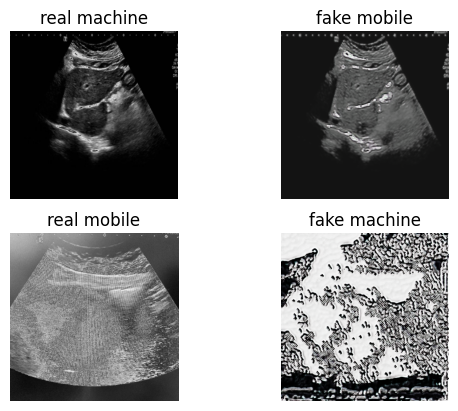

In [ ]:
import matplotlib.pyplot as plt

img_fake = plt.imread(f'outputs/ae_out_mobile_{0}.png')
img_real = plt.imread(f'outputs/ae_in_machine_{0}.png')
mimg_fake = plt.imread(f'outputs/ae_out_mobile_g{0}.png')
mimg_real = plt.imread(f'outputs/ae_in_machine_g{0}.png')

fig, axs = plt.subplots(2,2)
for i in range(4):
  axs[i//2, i%2].axis('off')
axs[0, 0].set_title('real machine')
axs[0, 1].set_title('fake mobile')
axs[1, 0].set_title('real mobile')
axs[1, 1].set_title('fake machine')
axs[0, 0].imshow(img_real)
axs[0, 1].imshow(img_fake)
axs[1, 0].imshow(mimg_real)
axs[1, 1].imshow(mimg_fake)

#Main

In [ ]:
disc_H = Discriminator(in_channels=256).to(DEVICE)
disc_Z = Discriminator(in_channels=256).to(DEVICE)
# gen_Z = Generator(img_channels=3, num_residuals=9).to(DEVICE)
# gen_H = Generator(img_channels=3, num_residuals=9).to(DEVICE)

In [ ]:
# use Adam Optimizer for both generator and discriminator
opt_disc = optim.AdamW(
    list(disc_H.parameters()) + list(disc_Z.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
    weight_decay=0.01
)

opt_gen = optim.AdamW(
    list(gen_Z.parameters()) + list(gen_H.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

L1 = nn.L1Loss()
mse = nn.MSELoss()

In [ ]:
if LOAD_MODEL:
    load_checkpoint(
        CHECKPOINT_GENERATOR_H,
        gen_H,
        # opt_gen,
        # LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_GENERATOR_Z,
        gen_Z,
        # opt_gen,
        # LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_DISCRIMINATOR_H,
        disc_H,
        # opt_disc,
        # LEARNING_RATE,
    )
    load_checkpoint(
        CHECKPOINT_DISCRIMINATOR_Z,
        disc_Z,
        # opt_disc,
        # LEARNING_RATE,
    )


=> Loading checkpoint


In [ ]:

dataset = NewMobileMachineUnpair(
    train_machine_paths,
    train_mobile_paths,
    transforms,
)
val_dataset = NewMobileMachineUnpair(
    val_machine_paths,
    val_mobile_paths,
    transforms,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
)
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

for epoch in range(NUM_EPOCHS):
    train_fn(
        disc_H,
        disc_Z,
        gen_Z,
        gen_H,
        loader,
        opt_disc,
        opt_gen,
        L1,
        mse,
        d_scaler,
        g_scaler,
    )

    if SAVE_MODEL:
        save_checkpoint(gen_H, opt_gen, filename=CHECKPOINT_GENERATOR_H)
        save_checkpoint(gen_Z, opt_gen, filename=CHECKPOINT_GENERATOR_Z)
        save_checkpoint(disc_H, opt_disc, filename=CHECKPOINT_DISCRIMINATOR_H)
        save_checkpoint(disc_Z, opt_disc, filename=CHECKPOINT_DISCRIMINATOR_Z)

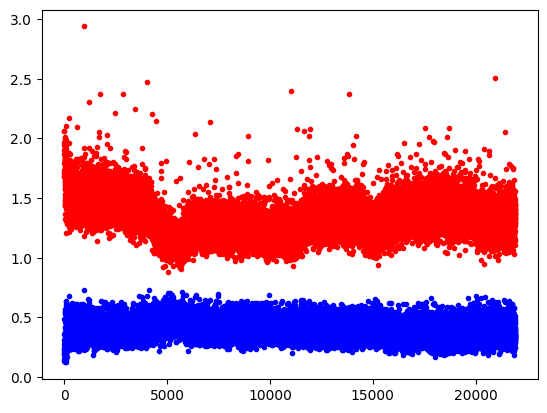

In [ ]:
import matplotlib.pyplot as plt

# losses['D'] = [loss.detach().numpy() for loss in losses['D']]
# losses['G'] = [loss.detach().numpy() for loss in losses['G']]

plt.plot(losses['D'], '.b')
plt.plot(losses['G'], '.r')
plt.show()

##Eval

In [ ]:
load_checkpoint(
    CHECKPOINT_GENERATOR_H,
    gen_H,
    opt_gen,
    LEARNING_RATE,
)
load_checkpoint(
    CHECKPOINT_GENERATOR_Z,
    gen_Z,
    opt_gen,
    LEARNING_RATE,
)

gen_H.eval()
gen_Z.eval()

=> Loading checkpoint
=> Loading checkpoint


Generator(
  (initial_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), padding_mode=reflect)
    (1): ReLU(inplace=True)
  )
  (downsampling_layers): ModuleList(
    (0): ConvolutionalBlock(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvolutionalBlock(
      (conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
  )
  (residual_layers): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): ConvolutionalBlock(
          (conv): Sequential(
            (0): Conv2d(256, 256, ker

In [ ]:
from statistics import mean

loss_fn = nn.L1Loss()
gen_H.eval()
gen_Z.eval()
val_loop = tqdm(val_loader, leave=True, position=0)
avg_loss_H = []
avg_loss_Z = []
with torch.no_grad():
  for idx, (machine, mobile) in enumerate(val_loop):
    machine = machine.to(DEVICE)
    mobile = mobile.to(DEVICE)
    torch.cuda.empty_cache()

    with torch.cuda.amp.autocast():
      fake_machine = gen_H(machine)
      fake_mobile = gen_Z(mobile)

      loss_H = loss_fn(fake_machine, machine)
      loss_Z = loss_fn(fake_mobile, mobile)

      avg_loss_H.append(loss_H.item())
      avg_loss_Z.append(loss_Z.item())

    val_loop.set_postfix(Machine_Loss=mean(avg_loss_H), Mobile_Loss=mean(avg_loss_Z))

  4%|▍         | 89/2000 [00:18<06:29,  4.91it/s, Machine_Loss=0.316, Mobile_Loss=0.621]


KeyboardInterrupt: 

In [ ]:
machine, mobile = next(iter(val_loader))[0]

machine = machine.to(DEVICE)
mobile = mobile.to(DEVICE)

machine.size()

torch.Size([3, 640, 640])

In [ ]:
from torchvision.utils import save_image

out = gen_H.decode(gen_Z.encode(machine))
save_image(out * 0.5 + 0.5, f"outputs/cross_ae_fake_{0}.png")
save_image(mobile * 0.5 + 0.5, f"outputs/cross_ae_real_{0}.png")

/home/ai4034/.conda/envs/newenv/lib/python3.10/site-packages/torch/nn/functional.py:1381: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


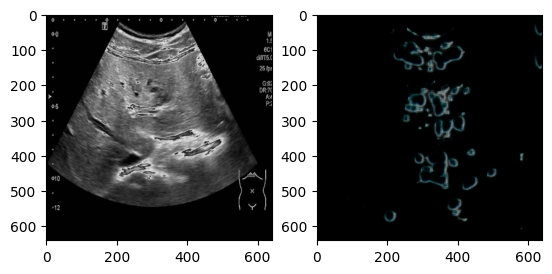

In [ ]:
import matplotlib.pyplot as plt

img_fake = plt.imread(f'outputs/cross_ae_fake_{0}.png')
img_real = plt.imread(f'outputs/cross_ae_real_{0}.png')
# plt.imshow('fake', img_fake)
# plt.imshow('real', img_real)
# plt.show()
fig, axs = plt.subplots(1,2)
axs[0].imshow(img_real)
axs[1].imshow(img_fake)

In [ ]:
!nvidia-smi

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

In [ ]:
!ls

#New Datasets

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {DEVICE}")

TRAIN_DIR = "data/train"
VAL_DIR = "data/val"
BATCH_SIZE = 1
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 0.0 # loss weight for identity loss
LAMBDA_CYCLE = 10
NUM_WORKERS = 4
NUM_EPOCHS = 50
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_GENERATOR_H = "models/genh.pth.tar"
CHECKPOINT_GENERATOR_Z = "models/genz.pth.tar"
CHECKPOINT_DISCRIMINATOR_H = "models/disch.pth.tar"
CHECKPOINT_DISCRIMINATOR_Z = "models/discz.pth.tar"

transforms = A.Compose(
    [
        A.Resize(width=1080, height=816),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
        ToTensorV2(),
    ],
    additional_targets={"image0": "image"},
)


using device: cuda


In [ ]:
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import pandas as pd
from random import randint

class MobileMachineUnpair(Dataset):
    def __init__(self, files_path, mapping, transform=None):
      self.transform = transform
      dir = files_path[0].split('/')[:-1]
      dir = '/'.join(dir)
      image_files_df = pd.DataFrame( { 'Image File':[file.split('/')[-1] for file in files_path] } )

      intersect = pd.merge(image_files_df, mapping, how ='inner', on ='Image File')

      intersect['Image File'] = intersect['Image File'].apply(lambda x: os.path.join(dir, x))

      self.mobile_positive = intersect[intersect['Type']=='mobile_positive']['Image File'].values
      self.mobile_negative = intersect[intersect['Type']=='mobile_negative']['Image File'].values

      self.machine_positive = intersect[intersect['Type']=='machine_positive']['Image File'].values
      self.machine_negative = intersect[intersect['Type']=='machine_negative']['Image File'].values

      self.len_map = len(self.machine_positive)
      self.len_mop =  len(self.mobile_positive)
      self.len_man = len(self.machine_negative)
      self.len_mon =  len(self.mobile_negative)


    def __len__(self):
      return max(self.len_mop, self.len_map) + max(self.len_mon, self.len_man)

    def __getitem__(self, idx):
      raw_id = idx
      if idx <= self.len_map - 1:
        m_idx = idx
        if idx > self.len_mop - 1:
          m_idx = randint(0, self.len_mop-1)
        return raw_id,self.transform(image=cv2.imread(self.machine_positive[idx]))['image'], self.transform(image=cv2.imread(self.mobile_positive[m_idx]))['image']
      else:
        idx -= self.len_map
        m_idx = idx
        if idx > self.len_mon - 1:
          m_idx = randint(0, self.len_mon-1)
        return raw_id,self.transform(image=cv2.imread(self.machine_negative[idx]))['image'], self.transform(image=cv2.imread(self.mobile_negative[m_idx]))['image']

In [ ]:
from glob import glob
import pandas as pd

train_file_paths = glob('datasets/train/images/*')
val_file_paths = glob('datasets/val/images/*')
mapping = pd.read_excel('mapping.xlsx')
len(train_file_paths), len(val_file_paths), len(mapping)

(14448, 4898, 19346)

In [ ]:
dataset = MobileMachineUnpair(
    train_file_paths,
    mapping,
    transforms,
)
val_dataset = MobileMachineUnpair(
    val_file_paths,
    mapping,
    transforms,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
)
loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [ ]:
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm
toimg = T.ToPILImage()

for idx, img1, img2 in tqdm(loader):
  # data = toimg(torch.cat([img1, img2], -1)[0])
  img1 = toimg(img1[0]).convert('L')
  img2 = toimg(img2[0]).convert('L')
  img1.save(f'pytorch-CycleGAN-and-pix2pix/datasets/newdataset/trainA/{int(idx[0])}.jpg')
  img2.save(f'pytorch-CycleGAN-and-pix2pix/datasets/newdataset/trainB/{int(idx[0])}.jpg')

100%|██████████| 13999/13999 [10:44<00:00, 21.71it/s]


In [ ]:
for idx, img1, img2 in tqdm(val_loader):
  # data = toimg(torch.cat([img1, img2], -1)[0])
  img1 = toimg(img1[0]).convert('L')
  img2 = toimg(img2[0]).convert('L')
  img1.save(f'pytorch-CycleGAN-and-pix2pix/datasets/newdataset/testA/{int(idx[0])}.jpg')
  img2.save(f'pytorch-CycleGAN-and-pix2pix/datasets/newdataset/testB/{int(idx[0])}.jpg')

100%|██████████| 3999/3999 [13:22<00:00,  4.99it/s]


##Test

In [ ]:
from PIL import Image
import torchvision.transforms as T
toimg = T.ToPILImage()

idx, img1, img2 = next(iter(loader))
img1 = toimg(img1[0])
img2 = toimg(img2[0])

tensor([0])


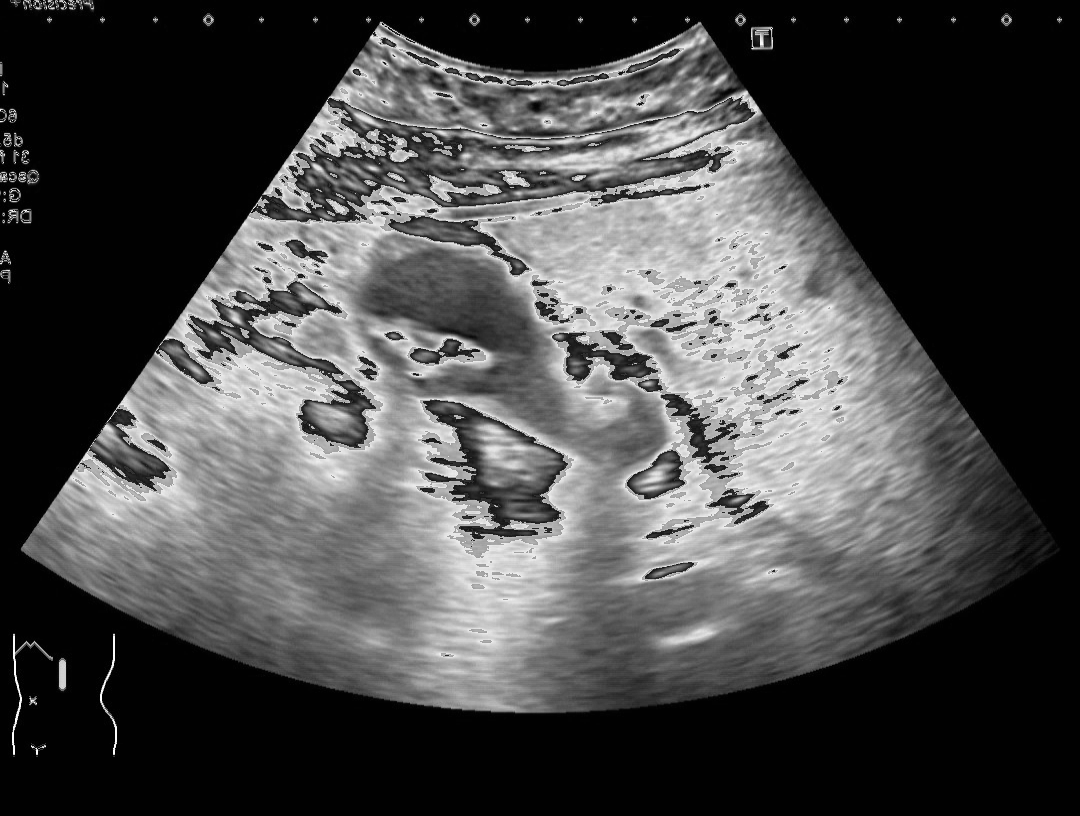

In [ ]:
print(idx)
img1.convert('L')

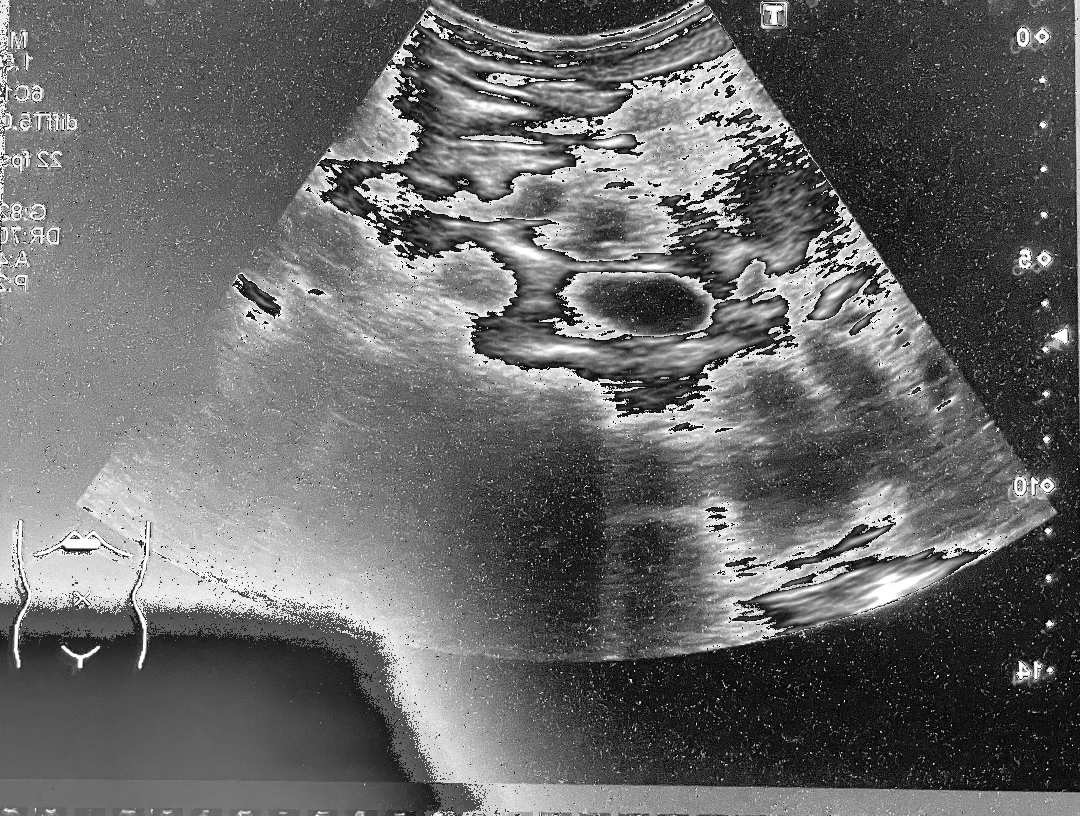

In [ ]:
img2.convert('L')

#From GAN dataset

##Functions

In [ ]:
from torch.utils.data import Dataset
class FromGanObjectDectection(Dataset):
    def __init__(self, files_path, transform):
      self.files_path = files_path
      self.transform = transform

    def __len__(self):
      return len(self.files_path)

    def __getitem__(self, idx):
      img = self.transform(image=cv2.imread(self.files_path[idx]))['image']
      path = self.files_path[idx]
      return img, path

In [ ]:
from glob import glob
import os

def extract_number(path):
    return int(path.split('/')[-1].split('.')[0])

train_directory = 'datasets/train/images'
file_paths = [os.path.join(train_directory, f) for f in os.listdir(train_directory)]

val_directory = 'datasts/val/images'
val_paths = sorted([os.path.join(val_directory, f) for f in os.listdir(val_directory)], key=extract_number)

test_directory = 'datasets/test/images'
test_paths = sorted([os.path.join(test_directory, f) for f in os.listdir(test_directory)], key=extract_number)

# train_paths = sorted(train_paths, key=extract_number)
# val_paths = sorted(val_paths, key=extract_number)
print(train_paths[:10])
print(val_paths[:10])
print(test_paths[:10], len(test_paths))

['datasets/train/images/2.jpg', 'datasets/train/images/18.jpg', 'datasets/train/images/30.jpg', 'datasets/train/images/51.jpg', 'datasets/train/images/72.jpg', 'datasets/train/images/94.jpg', 'datasets/train/images/106.jpg', 'datasets/train/images/112.jpg', 'datasets/train/images/121.jpg', 'datasets/train/images/123.jpg']
['datasets/val/images/4.jpg', 'datasets/val/images/13.jpg', 'datasets/val/images/15.jpg', 'datasets/val/images/16.jpg', 'datasets/val/images/25.jpg', 'datasets/val/images/32.jpg', 'datasets/val/images/37.jpg', 'datasets/val/images/44.jpg', 'datasets/val/images/50.jpg', 'datasets/val/images/55.jpg']
['datasets/test/images/1.jpg', 'datasets/test/images/3.jpg', 'datasets/test/images/5.jpg', 'datasets/test/images/6.jpg', 'datasets/test/images/7.jpg', 'datasets/test/images/8.jpg', 'datasets/test/images/9.jpg', 'datasets/test/images/10.jpg', 'datasets/test/images/11.jpg', 'datasets/test/images/12.jpg'] 5153


In [ ]:
from torch.utils.data import DataLoader
dataset = FromGanObjectDectection(
    train_paths,
    transforms,
)
val_dataset = FromGanObjectDectection(
    val_paths,
    transforms,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    pin_memory=True,
)
test_dataset = FromGanObjectDectection(
    test_paths,
    transforms,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    pin_memory=True,
)
loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    # num_workers=NUM_WORKERS,
    pin_memory=True,
)

##Train & Val

In [ ]:
from tqdm import tqdm
from torchvision.utils import save_image

idx = 0
for img1, path in tqdm(loader):
  torch.cuda.empty_cache()
  img1 = img1.to(DEVICE)
  with torch.no_grad():
    img1 = gen_H(img1)

    save_image(img1[0] * 0.5 + 0.5, path[0])
    save_image(img1[1] * 0.5 + 0.5, path[1])
  idx += 2

100%|██████████| 7224/7224 [14:11<00:00,  8.48it/s]


In [ ]:
idx = 0
for img1, path in tqdm(val_loader):
  torch.cuda.empty_cache()
  img1 = img1.to(DEVICE)
  with torch.no_grad():
    img1 = gen_H(img1)

    save_image(img1[0] * 0.5 + 0.5, path[0])
    save_image(img1[1] * 0.5 + 0.5, path[1])
  idx += 2

100%|██████████| 2449/2449 [07:19<00:00,  5.57it/s]


##Test

In [ ]:
idx = 0
for img1, path in tqdm(test_loader):
  torch.cuda.empty_cache()
  img1 = img1.to(DEVICE)
  with torch.no_grad():
    img1 = gen_H(img1)

    save_image(img1[0] * 0.5 + 0.5, path[0])
    save_image(img1[1] * 0.5 + 0.5, path[1])
  idx += 2

100%|█████████▉| 2576/2577 [14:00<00:00,  3.07it/s]


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [ ]:
path

['datasets/val/images/149985.jpg', 'datasets/val/images/149998.jpg']

#My YOLO

In [ ]:
import torch

print(f'Setup complete. Using torch {torch.__version__}')
print(f"{torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'}")

Setup complete. Using torch 2.3.0+cu121
NVIDIA A100-SXM4-40GB


In [ ]:
import os

HOME = os.getcwd()
print(HOME)

/lustrefs/disk/project/lt900104-ai24e4/Junior


In [ ]:
import ultralytics

ultralytics.checks()

Ultralytics YOLOv8.1.34 🚀 Python-3.10.14 torch-2.3.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40338MiB)
Setup complete ✅ (64 CPUs, 502.7 GB RAM, 0.2/251.4 GB disk)


In [ ]:
!yolo task=detect mode=train epochs=70 batch=32 plots=True model=yolov10x.pt data=jetdataset/datasets/data-liver.yaml cos_lr=True seed=888 dropout=0.0001 conf=0.75 augment=False auto_augment=False patience=10

Ultralytics YOLOv8.1.34 🚀 Python-3.10.14 torch-2.3.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40338MiB)
engine/trainer: task=detect, mode=train, model=yolov10x.pt, data=jetdataset/datasets/data-liver.yaml, epochs=70, time=None, patience=10, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train18, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=888, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0001, val=True, split=val, save_json=False, save_hybrid=False, conf=0.75, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fals

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Fri May 31 01:40:52 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:41:00.0 Off |                    0 |
| N/A   36C    P0    56W / 400W |   6805MiB / 40960MiB |      0%   E. Process |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------